In [1]:
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
from file_manager import load_system, select_atoms_by_Z, json_to_multiple_txt
from information_measures import *
import json

BASE_PATH = "COEFS"

neutral_atom = load_system(0, BASE_PATH)
atoms_selected = select_atoms_by_Z(neutral_atom, range(3, 55))

# Abrir el archivo JSON
data = []
with open('resultsJTD-neu.json', 'r', encoding='utf-8') as f:
    data.append(json.load(f))
with open('resultsEntropicMoment-neu.json', encoding='utf-8') as f:
    data.append(json.load(f))
with open('resultsQSIa-neu.json', encoding='utf-8') as f:
    data.append(json.load(f))
with open('resultsJRD-neu.json', encoding='utf-8') as f:
    data.append(json.load(f))

print(data)


[{'JTD - momento alpha=2.250-neu': [{'Z': 3, 'Q': 0, 'alpha': 2.25, 'JTD': 0.023284681415601284, 'integration_error': 1.4449733860399244e-07, 'space': 'momentum'}, {'Z': 4, 'Q': 0, 'alpha': 2.25, 'JTD': 0.0012208170733574886, 'integration_error': 1.1709396867691426e-07, 'space': 'momentum'}, {'Z': 5, 'Q': 0, 'alpha': 2.25, 'JTD': 5.067751434958648e-05, 'integration_error': 5.774317914561378e-08, 'space': 'momentum'}, {'Z': 6, 'Q': 0, 'alpha': 2.25, 'JTD': 4.52735046198901e-06, 'integration_error': 1.1307328366744529e-07, 'space': 'momentum'}, {'Z': 7, 'Q': 0, 'alpha': 2.25, 'JTD': 6.31303217624239e-07, 'integration_error': 1.1717696075310711e-07, 'space': 'momentum'}, {'Z': 8, 'Q': 0, 'alpha': 2.25, 'JTD': 1.1107225208467698e-07, 'integration_error': 3.094864622805878e-08, 'space': 'momentum'}, {'Z': 9, 'Q': 0, 'alpha': 2.25, 'JTD': 2.507673562627671e-08, 'integration_error': 1.9316643570962254e-10, 'space': 'momentum'}, {'Z': 10, 'Q': 0, 'alpha': 2.25, 'JTD': 6.789123673581476e-09, 'i

In [2]:
#Combinamos la información del json con la infomación de los átomo
def combine_atom_info(magnitud):
    with open(f'results{magnitud}-neu.json', 'r', encoding='utf-8') as f:
        data = json.load(f)

    
    for jtd in data.keys():
        for atom in atoms_selected:
            for diccionario in data[jtd]:
                if diccionario['Z'] == atom.Z:
                    diccionario['N'] = atom.N
                    diccionario['energy'] = atom.energy
                    diccionario['clasificacion'] = atom.clasification
                    diccionario['ionizacion'] = atom.ionization
                    diccionario['simbolo'] = atom.Symbol
                    diccionario['radio'] = atom.atomic_radius
                    diccionario['electronegatividad'] = atom.electronegativity
        # Guardar el diccionario modificado en un nuevo archivo JSON
    with open(f'results{magnitud}-neu-ampliado.json', 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    return 

magnitudes = ['JTD', 'EntropicMoment', 'QSIa', 'JRD']
for magnitud in magnitudes:
    combine_atom_info(magnitud)

In [9]:
#importamos datos como un json
with open('resultsFull-neu-ampliado.json', 'w', encoding='utf-8') as f:
    json.dump(datos, f, ensure_ascii=False, indent=4)

In [44]:
import plotly.graph_objects as go
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Cargar el archivo JSON
file_path = Path("resultsJTD-neu-ampliado.json")
with open(file_path, "r") as f:
    data = json.load(f)

# Convertir los datos en un DataFrame para facilitar su manejo
entries = []
for label, records in data.items():
    for record in records:
        record["label"] = label
        entries.append(record)

df = pd.DataFrame(entries)
df =df[df["space"]=="position"].copy()
# Asegurar que JTD > 0 y calcular log10(JTD)
df = df[df["JTD"] > 0].copy()
df = df[(df["alpha"] == 0.5) | (df["alpha"] == 3)].copy()  # Filtrar valores extremos
df["JTD_log"] = np.log10(df["JTD"])
df["alpha"] = df["alpha"].round(2)


# Corregir el mapa de símbolos con valores válidos para Scatter3d
symbol_map = {
    "Alkali metal": "circle",
    "Alkaline earth metal": "square",
    "Transition metal": "diamond",
    "Post-transitional metal": "cross",
    "Metaloid": "x",
    "Non metal": "circle-open",
    "Noble gas": "diamond-open"
}

# Regenerar la figura después del error de conexión
fig = go.Figure()

# Crear trazas por clasificación con símbolos y color por log10(JTD)
for clasificacion, group in df.groupby("clasificacion"):
    fig.add_trace(go.Scatter3d(
        x=group["N"],
        y=group["alpha"],
        z=group["JTD_log"],
        mode='markers',
        marker=dict(
        size=3,
        color=df["energy"],
        colorscale='Viridis',
        colorbar=dict(
            title="Energy",
            x=1.15,        # Moverla más a la derecha
            y=0.5,         # Centrada verticalmente
            len=0.8,       # Ajustar altura de la barra
            thickness=15   # Ajustar ancho de la barra
        ),
        symbol=symbol_map.get(clasificacion, "circle")
    ),
        name=clasificacion
    ))

# Configurar diseño
fig.update_layout(
    title="Visualización 3D de log10(JTD) con Clasificación de Elementos",
    scene=dict(
        
        bgcolor='black',
        xaxis_title="N",
        yaxis_title="alpha",
        zaxis_title="Energía", 
        xaxis=dict(backgroundcolor='black'),
        yaxis=dict(backgroundcolor='black'),
        zaxis=dict(backgroundcolor='black')
    ),
    legend=dict(
        x=0.01,
        y=0.99,
        bgcolor='rgba(255,255,255,0.7)'
    )
)

fig.show()
fig.write_html("grafico_con_energias_filtrado.html")



C:\Users\Ivan_lg\AppData\Local\Temp\ipykernel_23672\4281628674.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


'subfigures_2D_alpha.png'

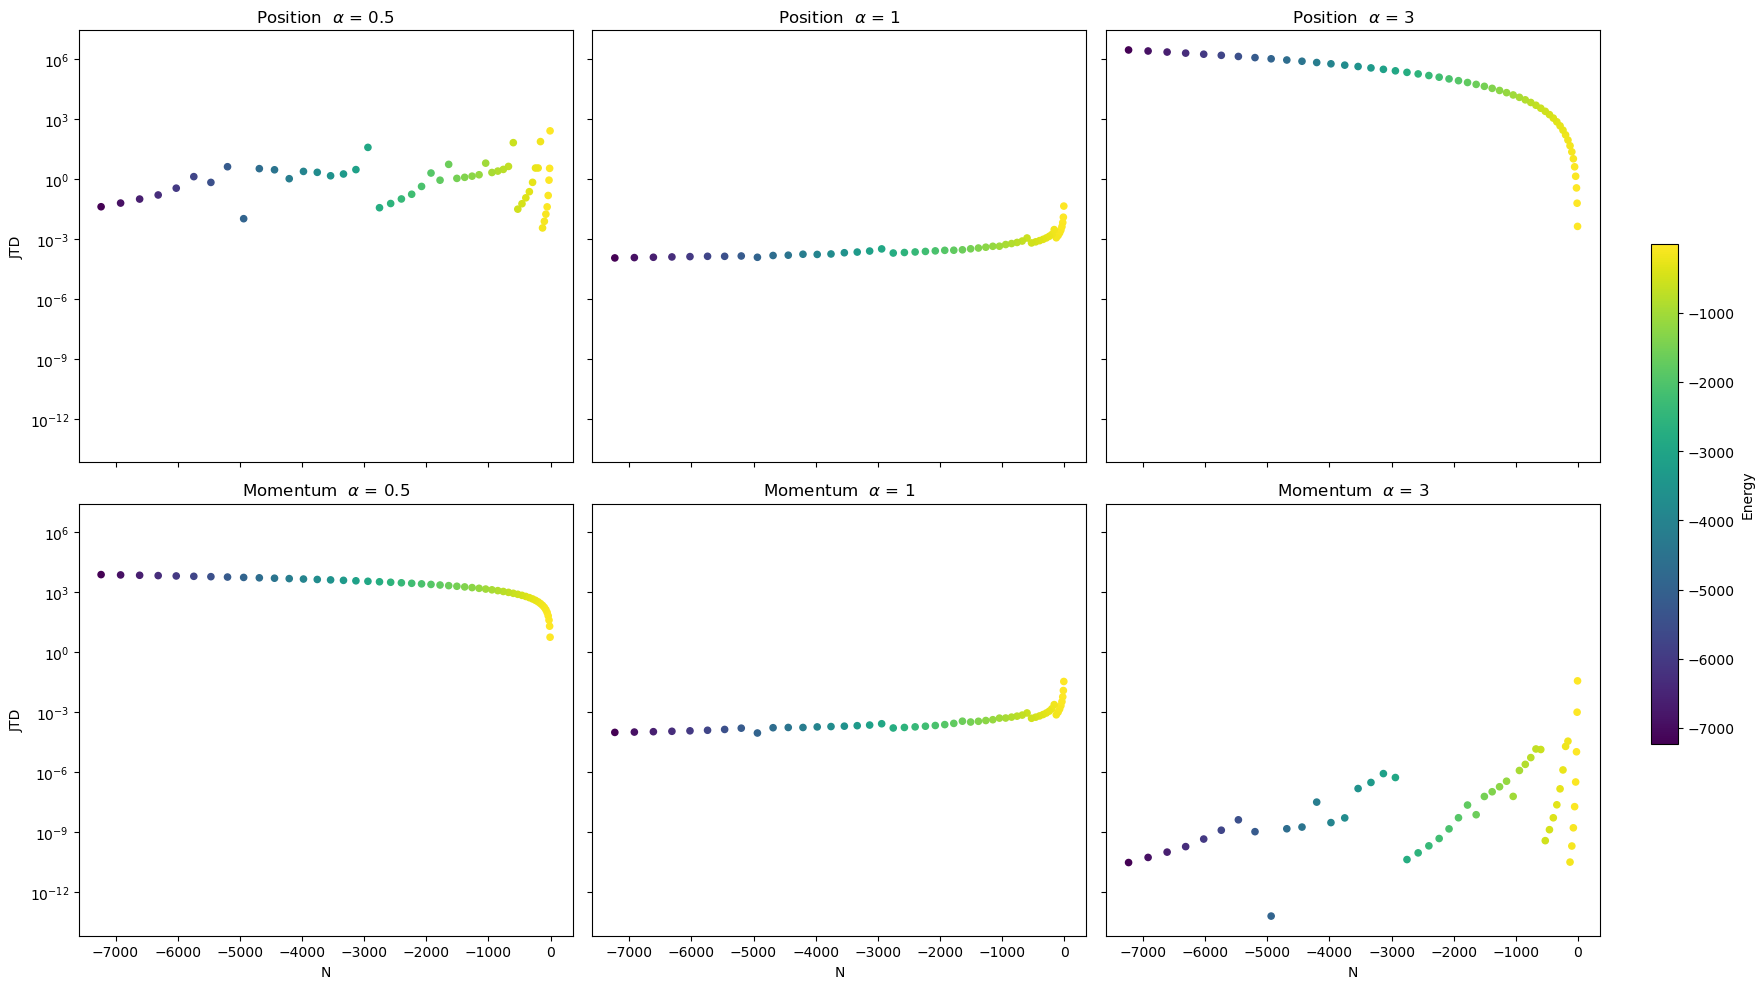

In [ ]:
# Reimportar módulos tras la aclaración del usuario
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Cargar el archivo JSON
file_path = Path("resultsFull-neu-ampliado.json")
with open(file_path, "r") as f:
    data = json.load(f)

# Preparar DataFrame
alpha_values = [0.5, 1, 3]
q_values = [0.5, 1, 3]

entries = []
for label, records in data.items():
    for record in records:
        record["label"] = label
        entries.append(record)

df = pd.DataFrame(entries)
df = df[df["alpha"].isin(alpha_values)].copy()
df["alpha"] = df["alpha"].round(2)

# Crear figura con 2 filas (posición y momento) y 3 columnas (alpha = 0.5, 1, 3)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True, sharex=True)
spaces = ["position", "momentum"]

# Dibujar cada subfigura
for i, alpha_val in enumerate(alpha_values):
    for j, space in enumerate(spaces):
        ax = axes[j, i]
        subset = df[(df["alpha"] == alpha_val) & (df["space"] == space)]
        sc = ax.scatter(subset["energy"], subset["JTD"], c=subset["energy"], cmap='viridis', s=20)
        ax.set_yscale("log")
        ax.set_title(rf"{space.capitalize()}  $\alpha$ = {alpha_val}")
        if j == 1:
            ax.set_xlabel("N")
        if i == 0:
            ax.set_ylabel("JTD")

# Añadir barra de color común
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label("Energy")

plt.tight_layout(rect=[0, 0, 0.9, 1])
output_path = "subfigures_2D_alpha.png"
plt.savefig(output_path, dpi=300)

output_path


'subfigures_Z_JTD.png'

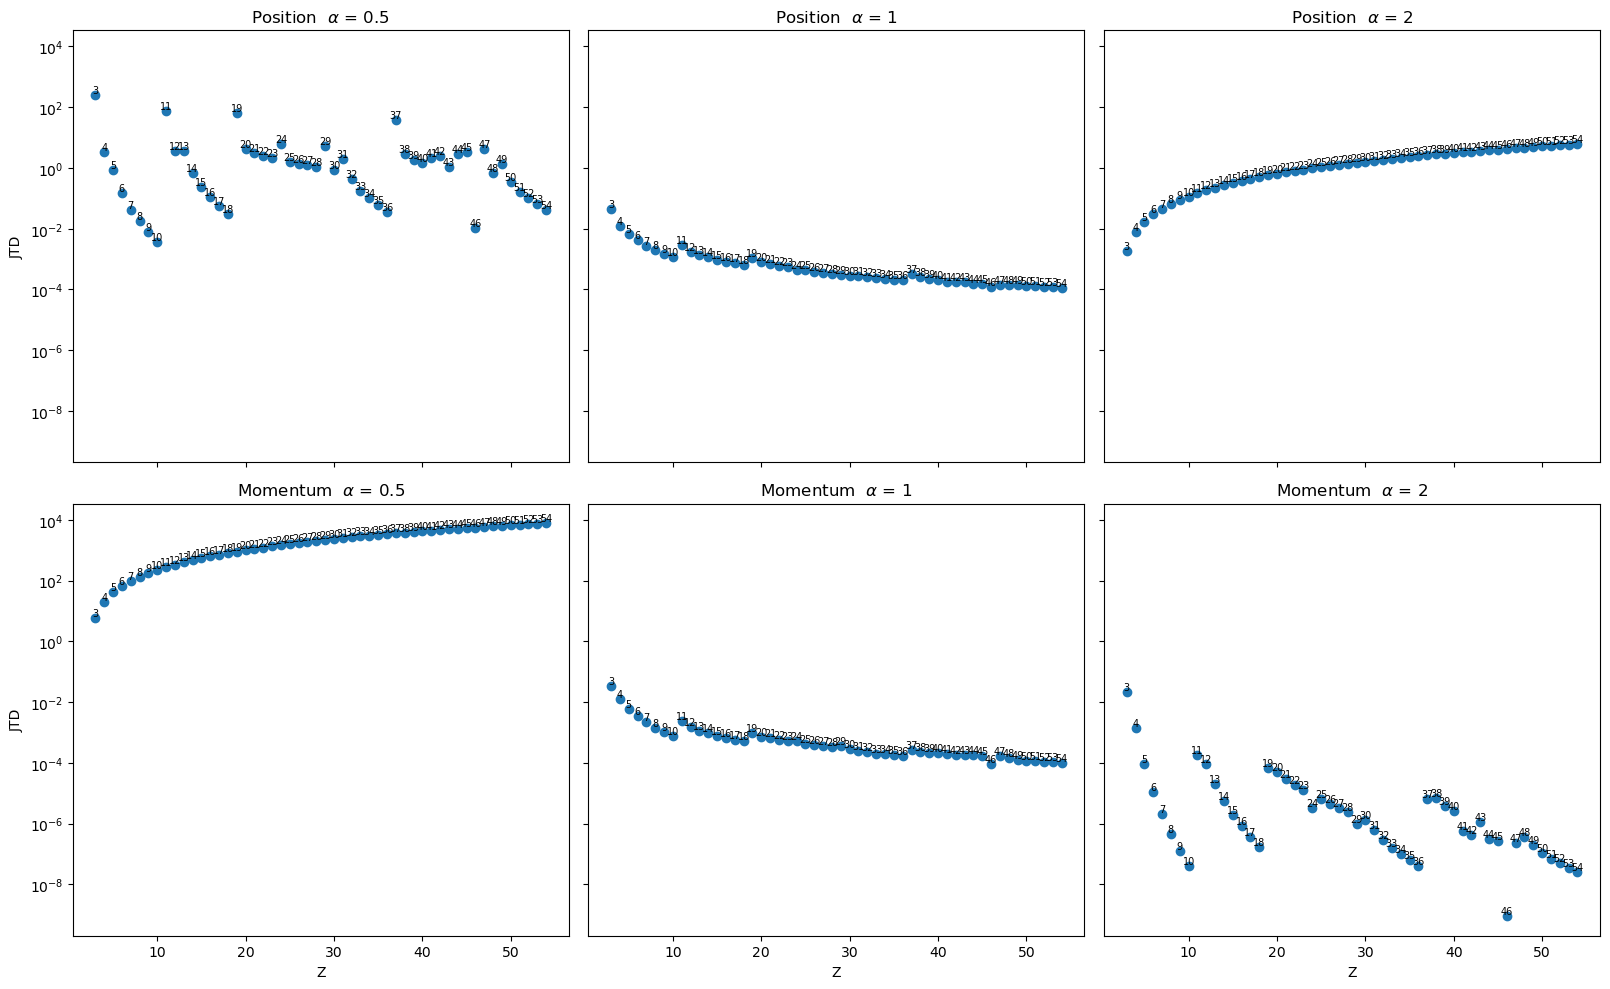

In [1]:
# Reimportar módulos tras la aclaración del usuario
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Cargar el archivo JSON
file_path = Path("resultsJTD-neu-ampliado.json")
with open(file_path, "r") as f:
    data = json.load(f)

# Preparar DataFrame
alpha_values = [0.5, 1, 2]

entries = []
for label, records in data.items():
    for record in records:
        record["label"] = label
        entries.append(record)

df = pd.DataFrame(entries)
df = df[df["alpha"].isin(alpha_values)].copy()
df["alpha"] = df["alpha"].round(2)

# Crear figura con 2 filas (posición y momento) y 3 columnas (alpha = 0.5, 1, 3)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True, sharex=True)
spaces = ["position", "momentum"]

# Dibujar cada subfigura
for i, alpha_val in enumerate(alpha_values):
    for j, space in enumerate(spaces):
        ax = axes[j, i]
        subset = df[(df["alpha"] == alpha_val) & (df["space"] == space)]
        
        sc = ax.scatter(subset["Z"], subset["JTD"])
        
        # Agregar etiquetas con el valor de N
        for _, row in subset.iterrows():
            ax.text(row["Z"], row["JTD"], str(int(row["Z"])), fontsize=7, ha='center', va='bottom')

        ax.set_yscale("log")
        ax.set_title(rf"{space.capitalize()}  $\alpha$ = {alpha_val}")
        
        if j == 1:
            ax.set_xlabel("Z")
        if i == 0:
            ax.set_ylabel("JTD")


plt.tight_layout(rect=[0, 0, 0.9, 1])
output_path = "subfigures_Z_JTD.png"
plt.savefig(output_path, dpi=300)

output_path


'subfigures_2D_alpha.png'

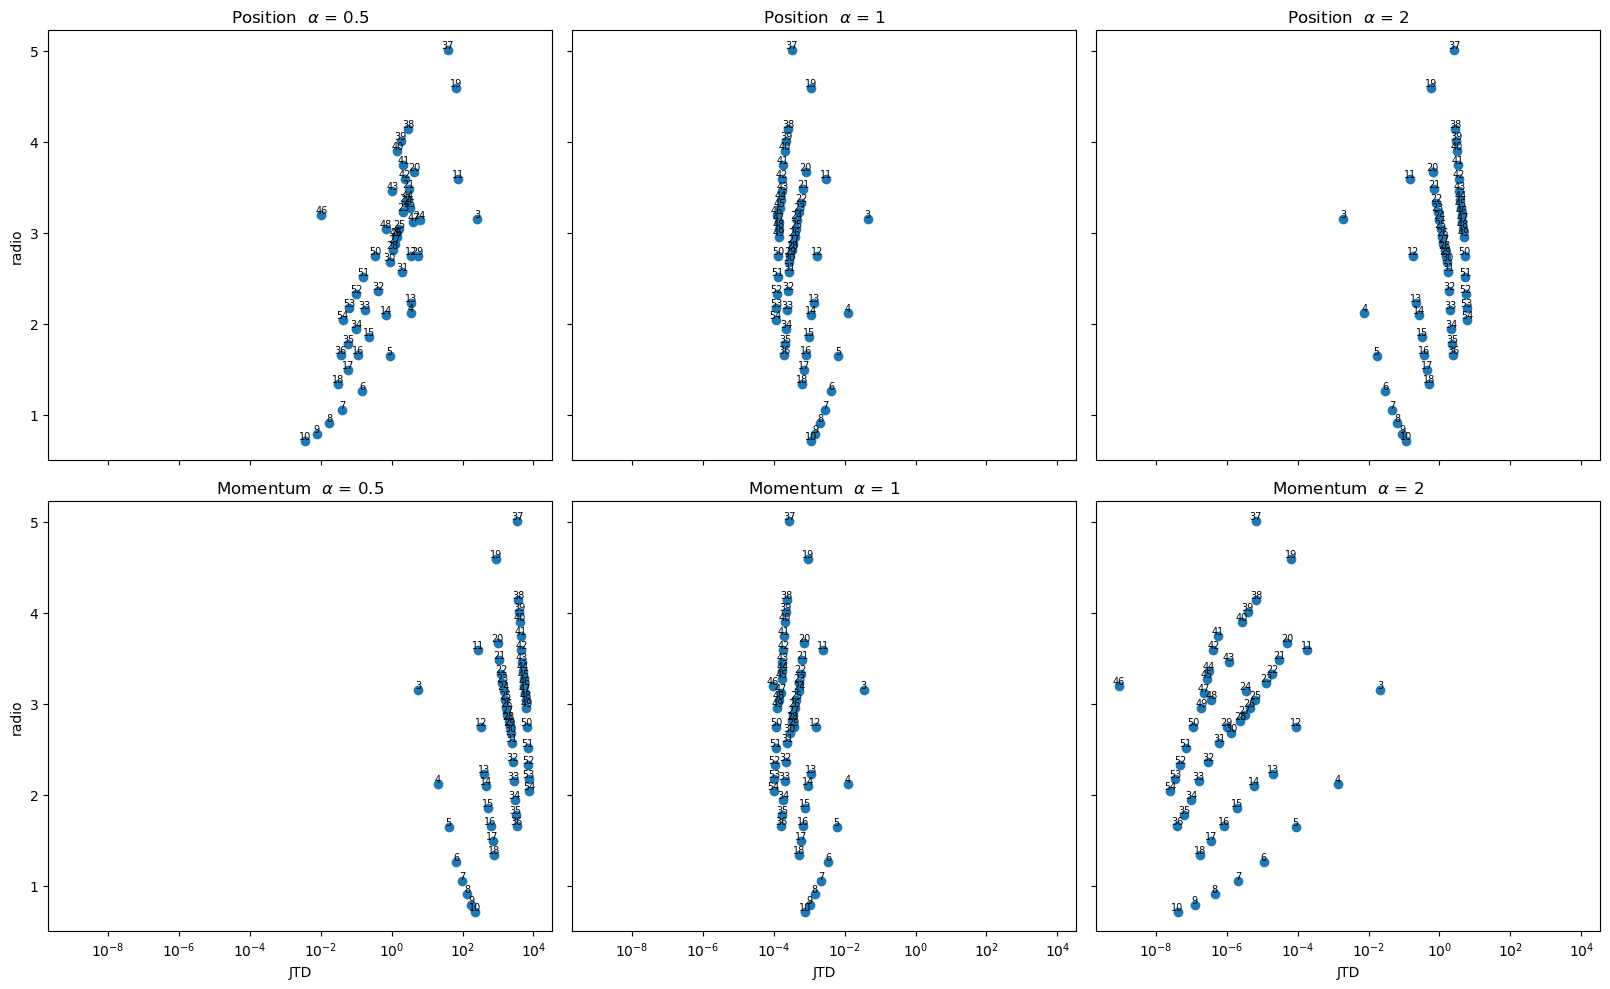

In [8]:
# Reimportar módulos tras la aclaración del usuario
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Cargar el archivo JSON
file_path = Path("resultsJTD-neu-ampliado.json")
with open(file_path, "r") as f:
    data = json.load(f)

# Preparar DataFrame
alpha_values = [0.5, 1, 2]

entries = []
for label, records in data.items():
    for record in records:
        record["label"] = label
        entries.append(record)

df = pd.DataFrame(entries)
df = df[df["alpha"].isin(alpha_values)].copy()
df["alpha"] = df["alpha"].round(2)

# Crear figura con 2 filas (posición y momento) y 3 columnas (alpha = 0.5, 1, 3)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True, sharex=True)
spaces = ["position", "momentum"]

# Dibujar cada subfigura
for i, alpha_val in enumerate(alpha_values):
    for j, space in enumerate(spaces):
        ax = axes[j, i]
        subset = df[(df["alpha"] == alpha_val) & (df["space"] == space)]
        
        sc = ax.scatter(subset["JTD"], subset["radio"]/ 52.9177)
        
        # Agregar etiquetas con el valor de N
        for _, row in subset.iterrows():
            ax.text(row["JTD"], row["radio"]/ 52.9177, str(int(row["Z"])), fontsize=7, ha='center', va='bottom')

        ax.set_xscale("log")
        ax.set_title(rf"{space.capitalize()}  $\alpha$ = {alpha_val}")
        
        if j == 1:
            ax.set_xlabel("JTD")
        if i == 0:
            ax.set_ylabel("radio")


plt.tight_layout(rect=[0, 0, 0.9, 1])
output_path = "subfigures_2D_alpha.png"
plt.savefig(output_path, dpi=300)

output_path


In [5]:
print(df)

       Z  Q  alpha       JTD  integration_error     space   N       energy  \
208    3  0    2.0  0.021288       1.488834e-07  momentum   3    -7.432727   
209    4  0    2.0  0.001376       1.470341e-07  momentum   4   -14.573023   
210    5  0    2.0  0.000088       1.291272e-07  momentum   5   -24.529061   
211    6  0    2.0  0.000011       2.200427e-08  momentum   6   -37.688619   
212    7  0    2.0  0.000002       5.251691e-08  momentum   7   -54.400934   
...   .. ..    ...       ...                ...       ...  ..          ...   
1139  50  0    1.0  0.000132       1.480048e-07  position  50 -6022.931689   
1140  51  0    1.0  0.000127       1.481476e-07  position  51 -6313.485314   
1141  52  0    1.0  0.000122       1.482758e-07  position  52 -6611.784051   
1142  53  0    1.0  0.000118       1.489042e-07  position  53 -6917.980888   
1143  54  0    1.0  0.000114       1.479699e-07  position  54 -7232.138356   

                clasificacion  ionizacion simbolo  radio  elect

'QSI_alpha-vs-radio_neu.png'

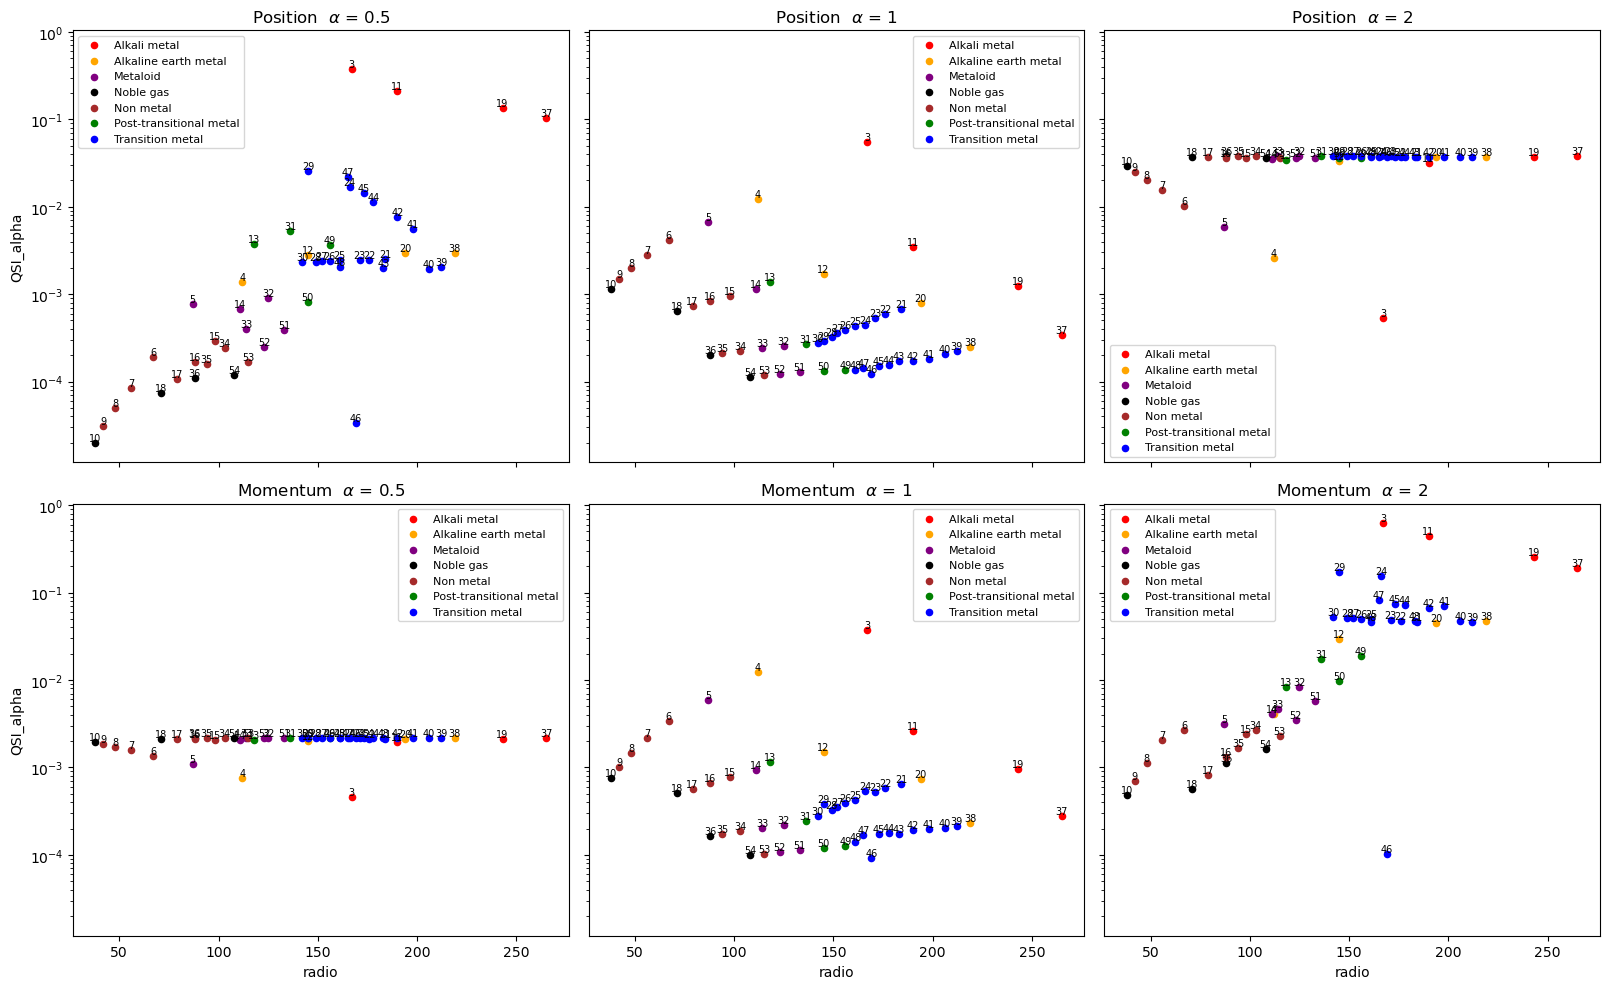

In [5]:
# Reimportar módulos tras la aclaración del usuario
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

magnitud = "QSIa"
prefijo = "neu"
x = "radio"

# Cargar el archivo JSON
file_path = Path(f"results{magnitud}-{prefijo}-ampliado.json")
with open(file_path, "r") as f:
    data = json.load(f)

# Preparar DataFrame
if magnitud == "JRD":
    alpha_values = [0.5, 0.75, 0.9, 1]
else: 
    alpha_values = [0.5, 1, 2]

entries = []
for label, records in data.items():
    for record in records:
        record["label"] = label
        entries.append(record)

df = pd.DataFrame(entries)
df = df[df["alpha"].isin(alpha_values)].copy()
df["alpha"] = df["alpha"].round(2)
#limpiar filas con valores NaN


# Crear figura con 2 filas (posición y momento) y 3 columnas (alpha = 0.5, 1, 3)
if magnitud == "JRD":
    fig, axes = plt.subplots(2, 4, figsize=(18, 10), sharey=True, sharex=True)
else:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True, sharex=True)
spaces = ["position", "momentum"]

# Dibujar cada subfigura

if magnitud == "QSIa":
    y = "QSI_alpha"
else:
    y = magnitud

if x == "electronegatividad" or y == "electronegatividad":
    df = df.dropna()

for i, alpha_val in enumerate(alpha_values):
    for j, space in enumerate(spaces):
        ax = axes[j, i]
        subset = df[(df["alpha"] == alpha_val) & (df["space"] == space)]
        
        #sc = ax.scatter(subset[x], subset[y])
                # Asignar un color por clasificación
        color_map = {
            "Alkali metal": "red",
            "Alkaline earth metal": "orange",
            "Transition metal": "blue",
            "Post-transitional metal": "green",
            "Metaloid": "purple",
            "Non metal": "brown",
            "Noble gas": "black",
            "Lanthanide": "cyan",
            "Actinide": "magenta"
        }


        # Dibujar cada grupo por clasificación con color específico
        for clasificacion, group in subset.groupby("clasificacion"):
            color = color_map.get(clasificacion, "gray")
            if y == "QSI_alpha":
                ax.scatter(group[x], 1-group[y], color=color, label=clasificacion, s=20)     
            else:
                ax.scatter(group[x], group[y], color=color, label=clasificacion, s=20)
                
            # Etiquetas de Z
            for _, row in group.iterrows():
                if y == "QSI_alpha":   
                    ax.text(row[x], 1-row[y], str(int(row["Z"])), fontsize=7, ha='center', va='bottom') 
                else:
                    ax.text(row[x], row[y], str(int(row["Z"])), fontsize=7, ha='center', va='bottom')
        if y == "JTD" or y== 'QSI_alpha' or y == "EntropicMoment" or y == "JRD":
            ax.set_yscale("log")
        if x == "JTD" or x == "QSI_alpha" or x == "EntropicMoment" or x == "JRD":
            ax.set_xscale("log")
        ax.set_title(rf"{space.capitalize()}  $\alpha$ = {alpha_val}")
        
        if j == 1:
            ax.set_xlabel(x)
        if i == 0:
            ax.set_ylabel(y)

        # Al final de cada subplot
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), fontsize=8)



plt.tight_layout(rect=[0, 0, 0.9, 1])
output_path = f"{y}-vs-{x}_{prefijo}.png"
plt.savefig(output_path, dpi=300)

output_path

In [10]:
print(df)

       Z  Q  alpha       JTD  integration_error     space   N       energy  \
208    3  0    2.0  0.021288       1.488834e-07  momentum   3    -7.432727   
209    4  0    2.0  0.001376       1.470341e-07  momentum   4   -14.573023   
210    5  0    2.0  0.000088       1.291272e-07  momentum   5   -24.529061   
211    6  0    2.0  0.000011       2.200427e-08  momentum   6   -37.688619   
212    7  0    2.0  0.000002       5.251691e-08  momentum   7   -54.400934   
...   .. ..    ...       ...                ...       ...  ..          ...   
1138  49  0    1.0  0.000137       1.486869e-07  position  49 -5740.169151   
1139  50  0    1.0  0.000132       1.480048e-07  position  50 -6022.931689   
1140  51  0    1.0  0.000127       1.481476e-07  position  51 -6313.485314   
1141  52  0    1.0  0.000122       1.482758e-07  position  52 -6611.784051   
1142  53  0    1.0  0.000118       1.489042e-07  position  53 -6917.980888   

                clasificacion  ionizacion simbolo  radio  elect

In [1]:
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
from file_manager import load_system, select_atoms_by_Z, json_to_multiple_txt
from information_measures import *
import json

BASE_PATH = "COEFS"

neutral_atom = load_system(0, BASE_PATH)
atoms_selected = select_atoms_by_Z(neutral_atom, range(3, 55))

In [2]:
results = EntropicMoment(atoms_selected[3:5], qs = 0.5, space="position", two_electron_density=True, product_density=True, average_density=True)

c:\Users\Ivan_lg\Desktop\Doctorado\SegundoAnio\TFGMariadelMar\Calculos\hartreeFock\information_measures.py:462: UserWarning: Space provided as string. Defaulting to same space for all atoms.
  warnings.warn("Space provided as string. Defaulting to same space for all atoms.", UserWarning)
